# [캡스톤 06] 로지스틱ㅣ🍎 사과 품질 분류

## 준비작업

### 패키지 참조

In [2]:
# 라이브러리 기본 참조
from hossam import load_data
from pandas import DataFrame, concat, crosstab, cut, get_dummies, merge
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
import numpy as np

# 로지스틱을 위한 참조
import statsmodels.api as sm

# 로지스틱의 결과 판별을 위한 참조
# -> 머신러닝 라이브러리를 미리 사용함
from sklearn.metrics import (
    confusion_matrix,
    roc_curve,
    roc_auc_score,
    accuracy_score,
    recall_score,
    precision_score,
    f1_score,
)

# VIF값을 계산하기 위한 참조
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 전처리
from sklearn.impute import SimpleImputer

# T-Test
from scipy.stats import ttest_ind
import pandas as pd
from IPython.display import display
import io

In [3]:
from hossam.stats import *
from hossam import my_dpi

### 그래프 초기화

```python
# 코드 생략
```

### 로지스틱 결과 보고 함수

```python
def hs_logit_report(fit, data):
    # ... 코드 생략 ...
```

### VIF 필터링 함수

```python
def hs_vif_filter(data, yname, ignore):
    # ... 코드 생략 ...
```

### 데이터 불러오기

In [4]:
origin = load_data("apple_quality")

print("\n===== 데이터 크기 확인 =====")
print(f"데이터셋 크기: {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")

print("\n===== 타입확인 =====")
print(origin.info())

origin.head()

[data] https://data.hossam.kr/data/kaggle/apple_quality.xlsx
[desc] 이 데이터 세트는 다양한 과일 속성에 대한 정보를 담고 있어 과일의 특성을 파악하는 데 도움이 됩니다. 데이터 세트에는 과일 ID, 크기, 무게, 당도, 아삭함, 과즙량, 숙성도, 산도 및 품질과 같은 세부 정보가 포함되어 있습니다. (출처: https://www.kaggle.com/datasets/nelgiriyewithana/apple-quality)

field        description
-----------  ----------------------------------
A_id         각 과일에 대한 고유 식별자
Size         크기
Weight       무게
Sweetness    단맛 정도
Crunchiness  과일의 아삭한 식감을 나타내는 질감
Juiciness    과일의 과즙 함량 정도
Ripeness     과일이 익은 정도
Acidity      과일의 산도 수준
Quality      과일의 전반적인 품질


===== 데이터 크기 확인 =====
데이터셋 크기: (4000, 9)
열 개수: 9
행 개수: 4000

===== 타입확인 =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   A_id         4000 non-null   int64  
 1   Size         4000 non-null   float64
 2   Weight       4000 non-null   float64
 3   Sweetness    4000 non-null   float64
 4   Crunc

,A_id,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality
0,0,-3.970049,-2.512336,5.346330,-1.012009,1.844900,0.329840,-0.491590,good
1,1,-1.195217,-2.839257,3.664059,1.588232,0.853286,0.867530,-0.722809,good
2,2,-0.292024,-1.351282,-1.738429,-0.342616,2.838636,-0.038033,2.621636,bad
3,3,-0.657196,-2.271627,1.324874,-0.097875,3.637970,-3.413761,0.790723,good
4,4,1.364217,-1.296612,-0.384658,-0.553006,3.030874,-1.303849,0.501984,good


## 1단계. 데이터와 첫인상 - “이 데이터는 어떤 세계를 보여주고 있을까?”

1. 데이터의 전체 구조를 확인하자.
   - 관측치 수
   - 변수 타입 (연속형 / 범주형)
2. 아직 분석을 하지 않은 상태에서 중요해 보이는 변수를 직관적으로 예측해 보자.

> 📌 **출제 의도**
> 이 단계는 데이터를 바로 분석 대상으로 보기보다,
> **현실의 대상(사과)을 설명하는 정보로 이해하는 연습**을 하기 위한 단계이다.
> 변수 이름을 해석하지 못하면 이후 분석도 설득력을 갖기 어렵다.

In [5]:
# 1단계 풀이: 데이터 구조와 첫인상
df = origin.copy()
df["Quality_bin"] = (df["Quality"] == "good").astype(int)

shape_info = pd.DataFrame({"관측치 수": [df.shape[0]], "변수 수": [df.shape[1]]})
categorical_cols = df.select_dtypes(include=["object"]).columns.tolist()
numeric_cols = [c for c in df.columns if c not in categorical_cols]

display(shape_info)
display(
    pd.DataFrame(
        {"범주형": [", ".join(categorical_cols)], "연속형": [", ".join(numeric_cols)]}
    )
)
display(df.isnull().sum().to_frame("결측치"))
display(df.head())
display(df.describe())

,관측치 수,변수 수
0,4000,10


,범주형,연속형
0,Quality,"A_id, Size, Weight, Sweetness, Crunchiness, Ju..."


,결측치
A_id,0
Size,0
Weight,0
Sweetness,0
Crunchiness,0
Juiciness,0
Ripeness,0
Acidity,0
Quality,0
Quality_bin,0


,A_id,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality,Quality_bin
0,0,-3.970049,-2.512336,5.346330,-1.012009,1.844900,0.329840,-0.491590,good,1
1,1,-1.195217,-2.839257,3.664059,1.588232,0.853286,0.867530,-0.722809,good,1
2,2,-0.292024,-1.351282,-1.738429,-0.342616,2.838636,-0.038033,2.621636,bad,0
3,3,-0.657196,-2.271627,1.324874,-0.097875,3.637970,-3.413761,0.790723,good,1
4,4,1.364217,-1.296612,-0.384658,-0.553006,3.030874,-1.303849,0.501984,good,1


,A_id,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality_bin
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,1999.500000,-0.503015,-0.989547,-0.470479,0.985478,0.512118,0.498277,0.076877,0.501000
std,1154.844867,1.928059,1.602507,1.943441,1.402757,1.930286,1.874427,2.110270,0.500062
min,0.000000,-7.151703,-7.149848,-6.894485,-6.055058,-5.961897,-5.864599,-7.010538,0.000000
25%,999.750000,-1.816765,-2.011770,-1.738425,0.062764,-0.801286,-0.771677,-1.377424,0.000000
50%,1999.500000,-0.513703,-0.984736,-0.504758,0.998249,0.534219,0.503445,0.022609,1.000000
75%,2999.250000,0.805526,0.030976,0.801922,1.894234,1.835976,1.766212,1.510493,1.000000
max,3999.000000,6.406367,5.790714,6.374916,7.619852,7.364403,7.237837,7.404736,1.000000


#### 💡 인사이트

- 관측치 4,000개, 변수 9개(연속형 7 + 식별자 1 + 목표변수 1)로 구성되어 있음.
- 범주형은 `Quality` 하나뿐이며 `A_id`는 식별자라 예측 변수에서 제외할 예정.
- 사과의 크기(`Size`), 당도(`Sweetness`), 과즙(`Juiciness`), 익은 정도(`Ripeness`)가 직관적으로 품질에 직접 연결될 가능성이 높아 보임.

## 2단계. 목표 변수 시각화 - “우리가 맞히려는 대상은 어떤 분포를 가지고 있을까?”

1. `Quality`의 분포를 막대그래프로 시각화하자.
2. 좋은 사과와 그렇지 않은 사과의 비율을 확인하자.
3. 이 분포를 보고 정확도 하나만으로 모델을 평가해도 괜찮을지 고민해 보자.

> 📌 **출제 의도**
> 분류 문제에서는 모델보다 먼저
> **무엇을 얼마나 자주 맞혀야 하는지**를 이해하는 것이 중요하다.
> 이 단계는 성능 지표를 선택하는 이유를 스스로 고민하게 하기 위함이다.

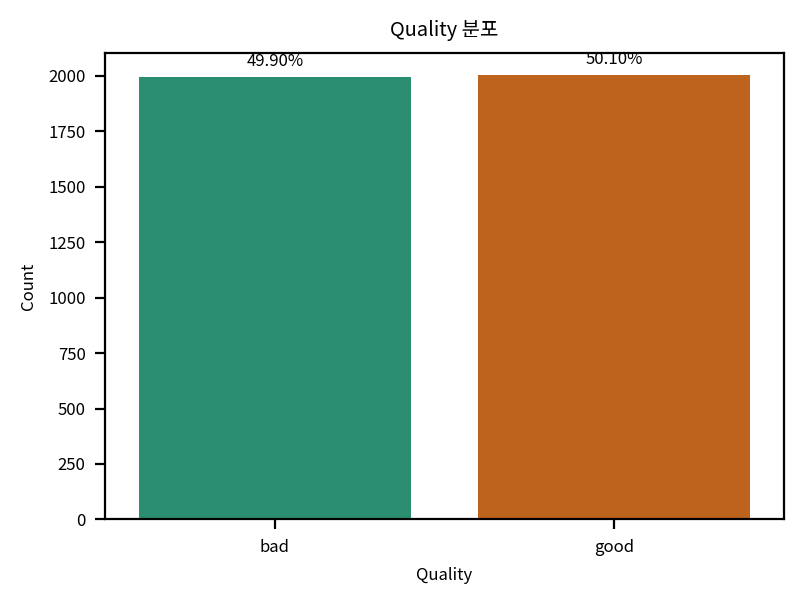

,count,ratio
Quality,,
bad,1996,0.499
good,2004,0.501


In [6]:
# 2단계 풀이: 목표 변수 시각화
quality_counts = df["Quality"].value_counts().sort_index()
quality_ratio = quality_counts / len(df)

plt.figure(figsize=(4, 3), dpi=my_dpi)
sb.countplot(
    data=df,
    x="Quality",
    hue="Quality",
    order=quality_counts.index,
    palette=["#d95f02", "#1b9e77"],
    legend=False,
)
for i, (cls, cnt) in enumerate(quality_counts.items()):
    plt.text(i, cnt + 30, f"{quality_ratio[cls]:.2%}", ha="center", va="bottom")
plt.title("Quality 분포")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

display(
    pd.concat([quality_counts.rename("count"), quality_ratio.rename("ratio")], axis=1)
)

#### 💡 인사이트

- `good` 50.1%, `bad` 49.9%로 거의 균형 잡힌 분포.
- 정확도만 써도 왜곡은 적지만 오분류 비용을 고려해 정밀도·재현율·AUC까지 함께 확인하는 것이 안전하다.

## 3단계. 단변량 EDA - “사과 하나만 놓고 보았을 때, 무엇이 보일까?”

각 연속형 변수에 대해 다음을 수행하자.

1. 히스토그램과 KDE를 그려 분포를 확인하자.
2. 왜도(skewness)가 있는 변수를 찾아보자.
3. 눈에 띄는 이상치가 있는지 시각적으로 판단하자.

> 📌 **출제 의도**
> 이 단계는 모델 성능을 높이기 위한 작업이 아니라, **데이터가 가진 기본적인 성질을 이해하는 과정**이다.
> 분포의 모양을 설명할 수 있다면 충분하다.

,skew
Sweetness,0.083850
Acidity,0.055783
Weight,0.003102
Crunchiness,0.000230
Size,-0.002437
Ripeness,-0.008764
Juiciness,-0.113421


Weight         54
Crunchiness    47
Sweetness      32
Juiciness      32
Ripeness       24
Size           22
Acidity        20
Name: outlier_count, dtype: int64

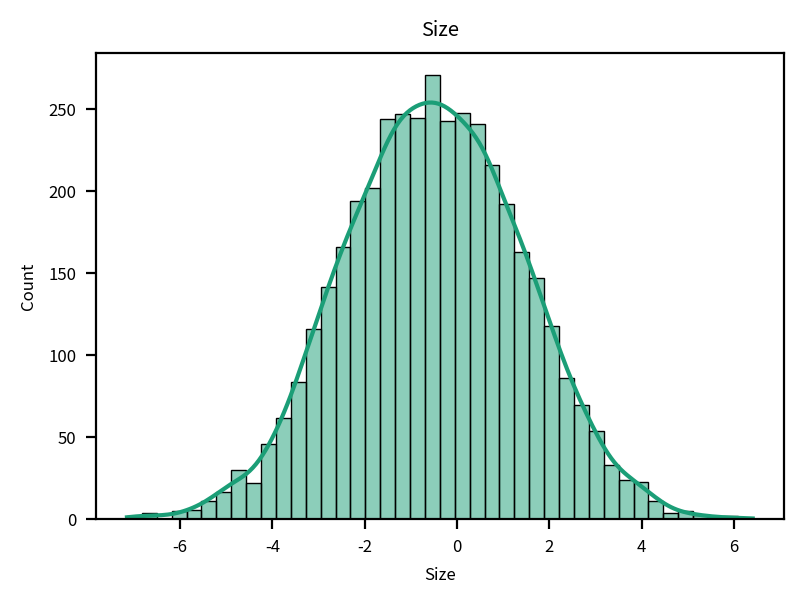

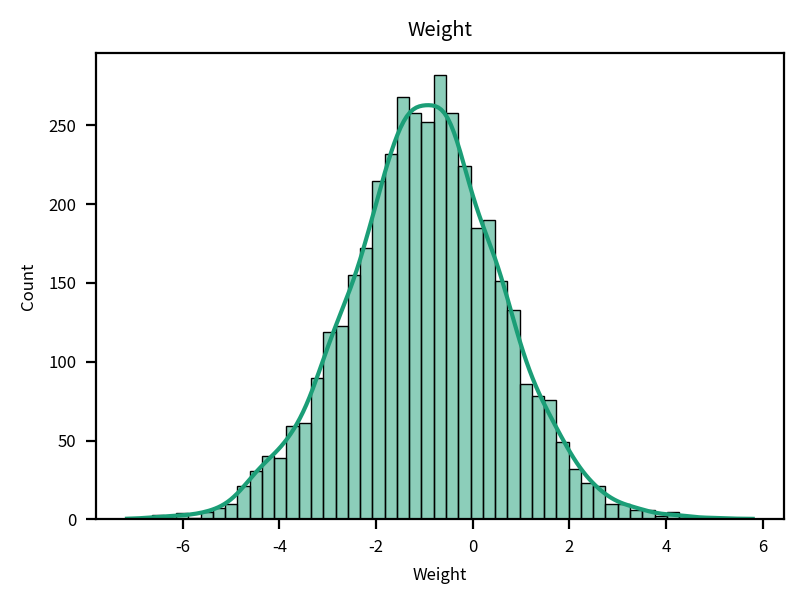

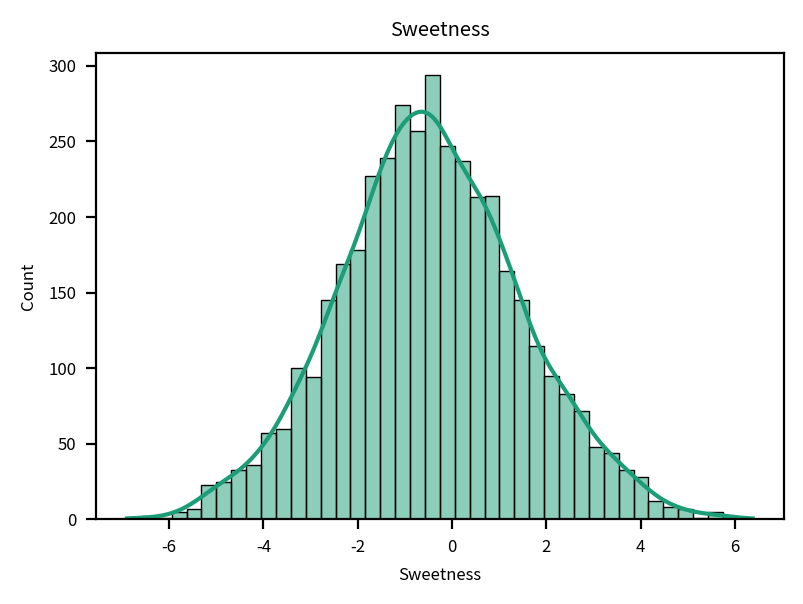

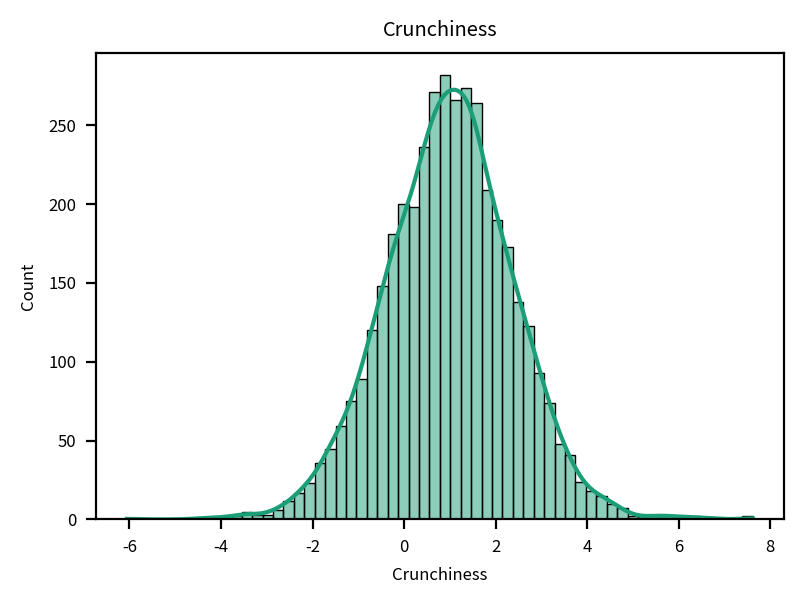

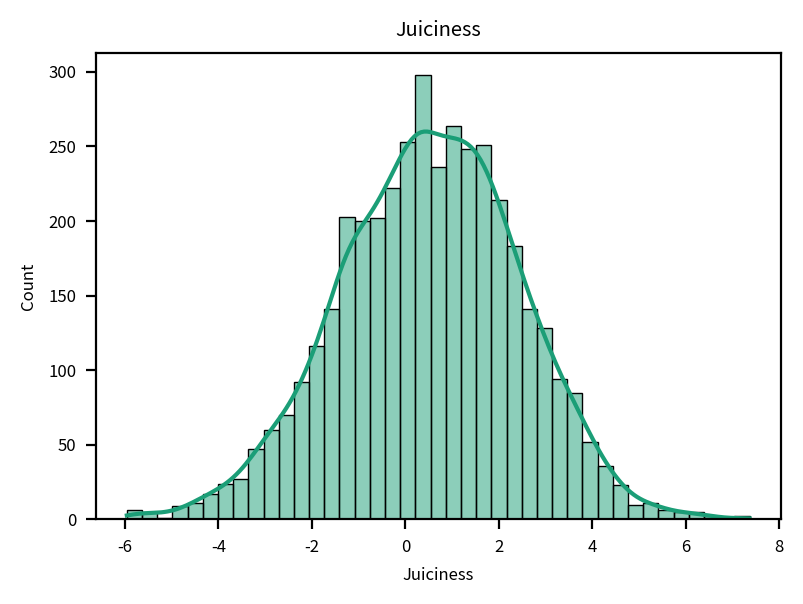

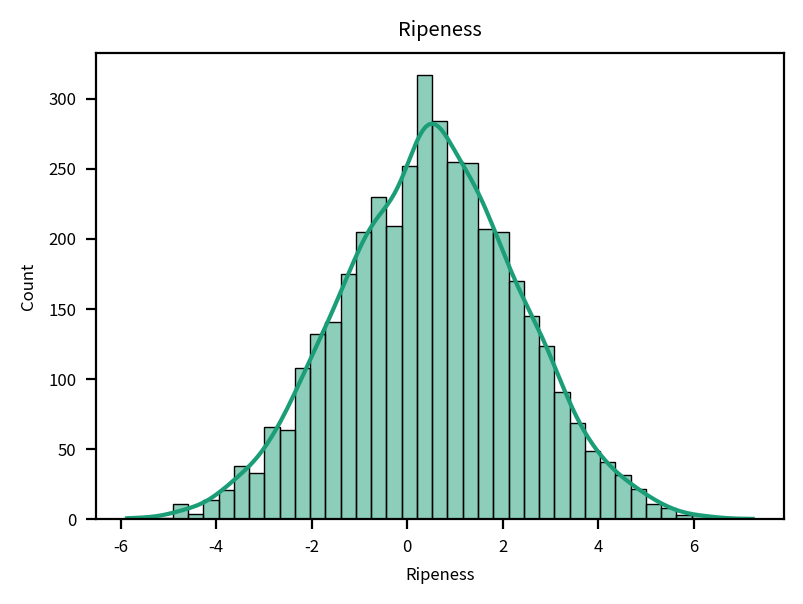

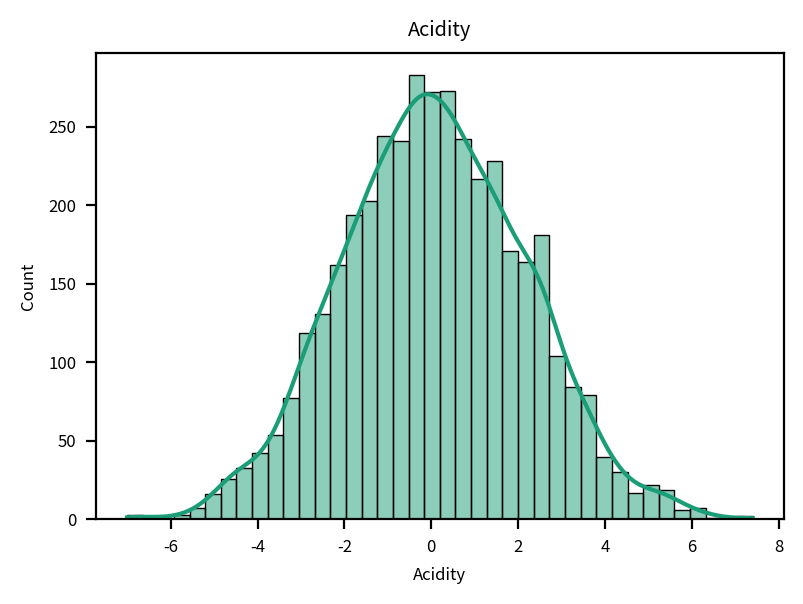

In [7]:
# 3단계 풀이: 단변량 EDA
feature_cols = [
    "Size",
    "Weight",
    "Sweetness",
    "Crunchiness",
    "Juiciness",
    "Ripeness",
    "Acidity",
]

skewness = df[feature_cols].skew().sort_values(ascending=False)
display(skewness.to_frame("skew"))

outlier_info = {}
for col in feature_cols:
    q1, q3 = df[col].quantile([0.25, 0.75])
    iqr = q3 - q1
    lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    outlier_info[col] = int(((df[col] < lower) | (df[col] > upper)).sum())
display(pd.Series(outlier_info, name="outlier_count").sort_values(ascending=False))

for col in feature_cols:
    plt.figure(figsize=(4, 3), dpi=my_dpi)
    sb.histplot(df[col], kde=True, color="#1b9e77", edgecolor="#000000", linewidth=0.5)
    plt.title(col)
    plt.tight_layout()
    plt.show()

#### 💡 인사이트

- 모든 연속형 변수의 왜도 절댓값이 0.1 이내로 대체로 대칭적이며 분포가 완만하다.
- IQR 기준 이상치는 `Weight`와 `Crunchiness`에서 상대적으로 많지만(50개 안팎) 전체 비중은 크지 않다.
- 극단치가 있으나 분포 왜곡이 심하지 않아 우선은 그대로 사용하고, 모델 적합 후 영향이 크면 추가로 조정할 수 있다.

## 4단계. 이변량 EDA - “품질에 따라 무엇이 달라질까?”

1. `Quality`를 기준으로 각 연속형 변수의 분포를 boxplot로 비교하자.
2. 중앙값 차이가 분명한 변수와 분포가 크게 겹치는 변수를 구분하자.
3. 분류에 도움이 될 것 같은 변수를 골라 보자.

> 📌 **출제 의도**
> 이 단계는 통계 검정 이전에
> **그래프를 근거로 판단하는 연습**을 하기 위한 단계이다.
> “그래서 이 변수가 중요해 보인다”라는 설명이 나오면 충분하다.

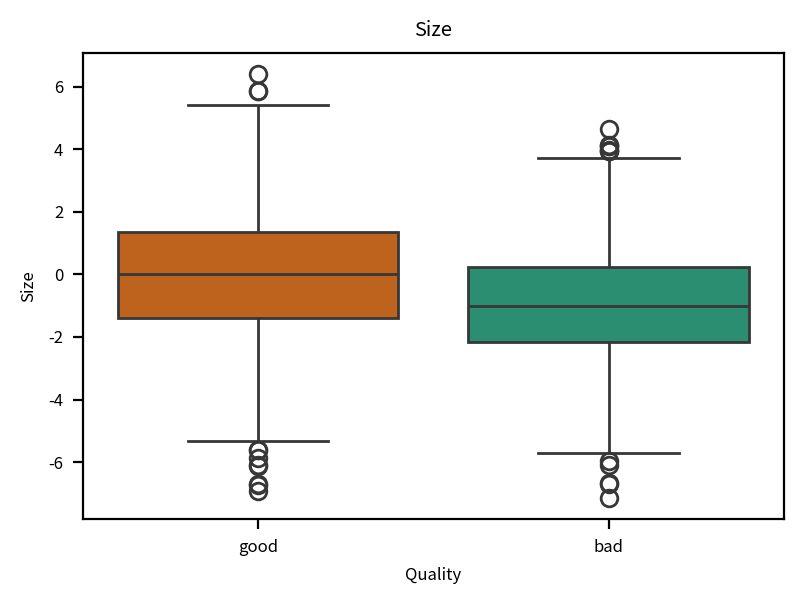

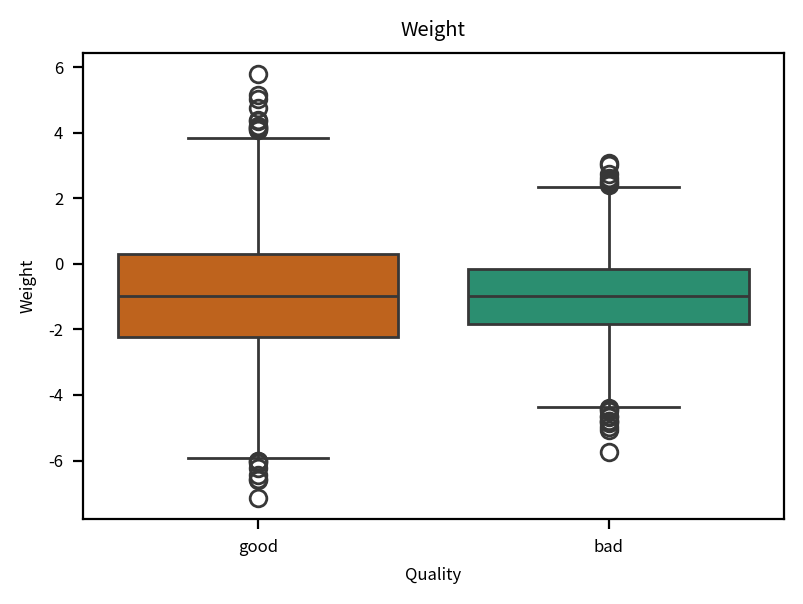

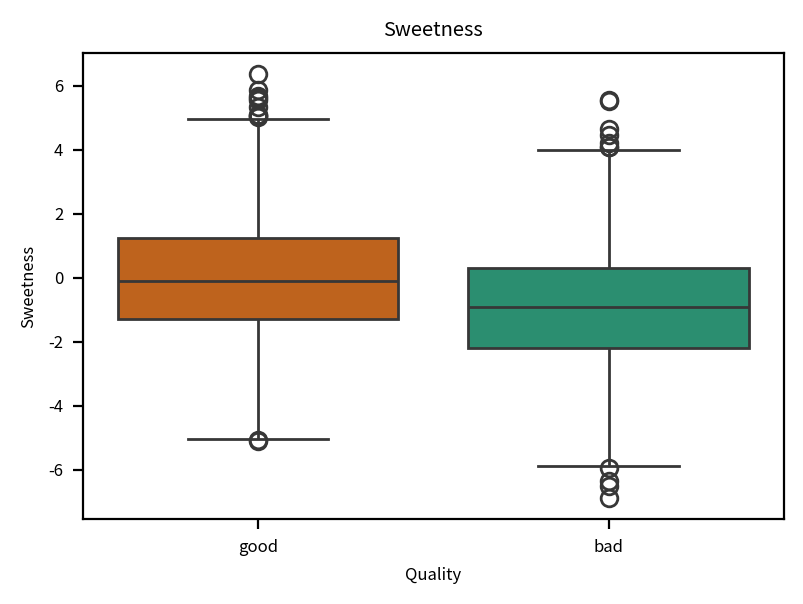

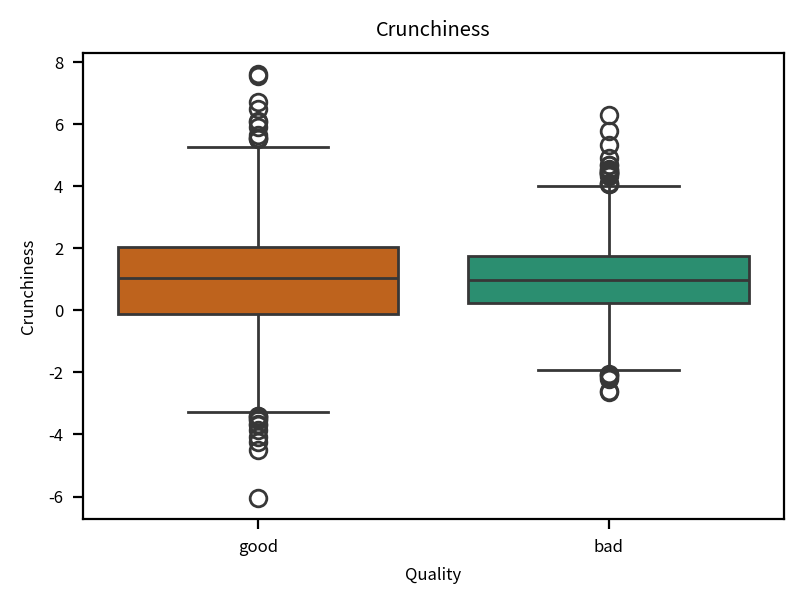

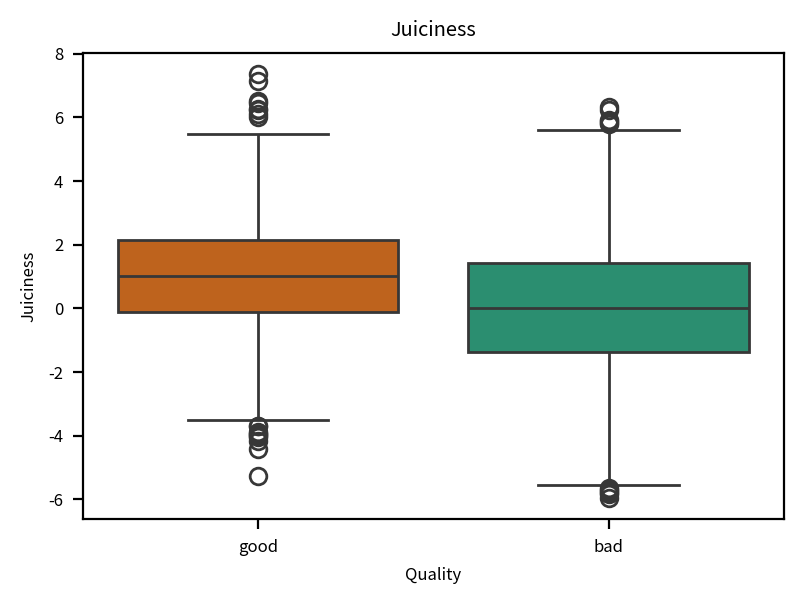

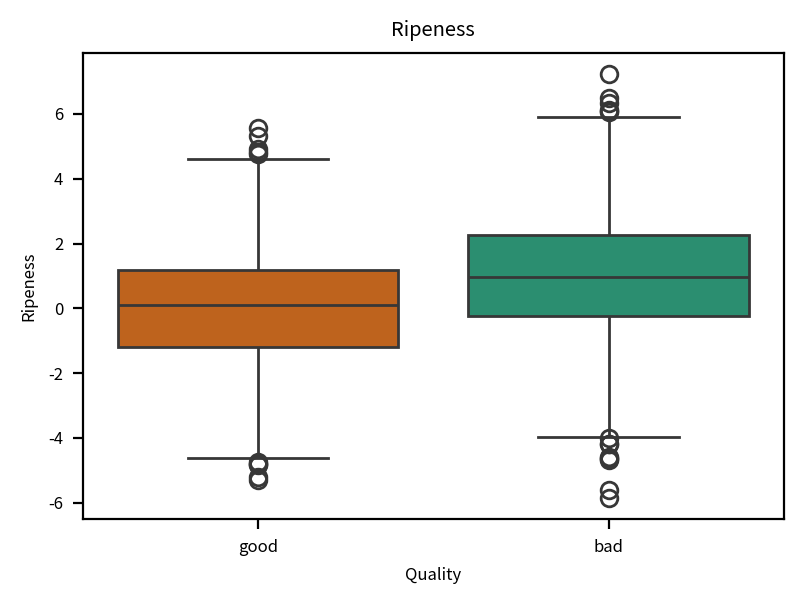

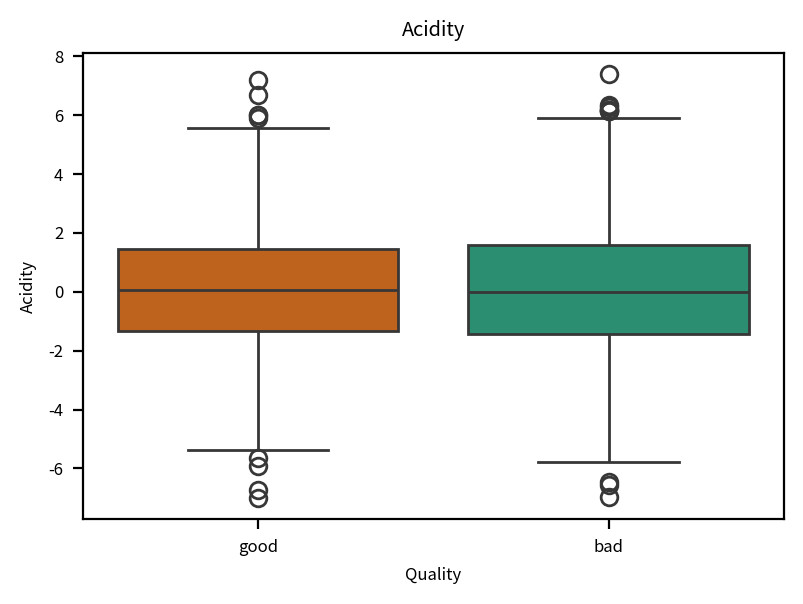

Quality,bad,good,good-bad
Size,-1.019633,0.025554,1.045187
Juiciness,0.005241,1.024190,1.018949
Sweetness,-0.921758,-0.116781,0.804977
Crunchiness,0.977615,1.049431,0.071816
Acidity,-0.010607,0.060766,0.071373
Weight,-0.975703,-0.994428,-0.018725
Ripeness,0.965054,0.095571,-0.869483


In [8]:
# 4단계 풀이: 품질별 분포 비교
feature_cols = [
    "Size",
    "Weight",
    "Sweetness",
    "Crunchiness",
    "Juiciness",
    "Ripeness",
    "Acidity",
]

for col in feature_cols:
    plt.figure(figsize=(4, 3), dpi=my_dpi)
    sb.boxplot(
        data=df,
        x="Quality",
        y=col,
        hue="Quality",
        palette=["#d95f02", "#1b9e77"],
        orient="v",
        legend=False,
    )
    plt.title(col)
    plt.tight_layout()
    plt.show()

median_gap = df.groupby("Quality")[feature_cols].median().T
median_gap["good-bad"] = median_gap["good"] - median_gap["bad"]
display(median_gap.sort_values("good-bad", ascending=False))

#### 💡 인사이트

- `Size`, `Sweetness`, `Juiciness`는 good 쪽 중앙값이 크게 높아 분류에 도움을 줄 만하다.
- `Ripeness`는 bad가 더 높아 과숙될수록 품질이 나빠지는 패턴을 보인다.
- `Weight`, `Crunchiness`, `Acidity`는 두 집단의 박스가 많이 겹쳐 단독 영향은 약할 것으로 보이며 보조 변수로만 활용한다.

## 5단계. 변수 간 관계 탐색 - “변수들은 서로 독립적일까?”

1. 연속형 변수들의 상관계수를 계산하자.
2. 상관행렬을 히트맵으로 시각화하자.
3. 상관이 높은 변수들을 동시에 사용할 때의 문제점을 고민해 보자.

> 📌 **출제 의도**
> 여러 변수를 함께 사용할 때 발생할 수 있는
> **정보 중복과 해석상의 어려움**을 인식하는 것이 목적이다.
> 복잡한 용어보다 직관적인 설명이 더 중요하다.

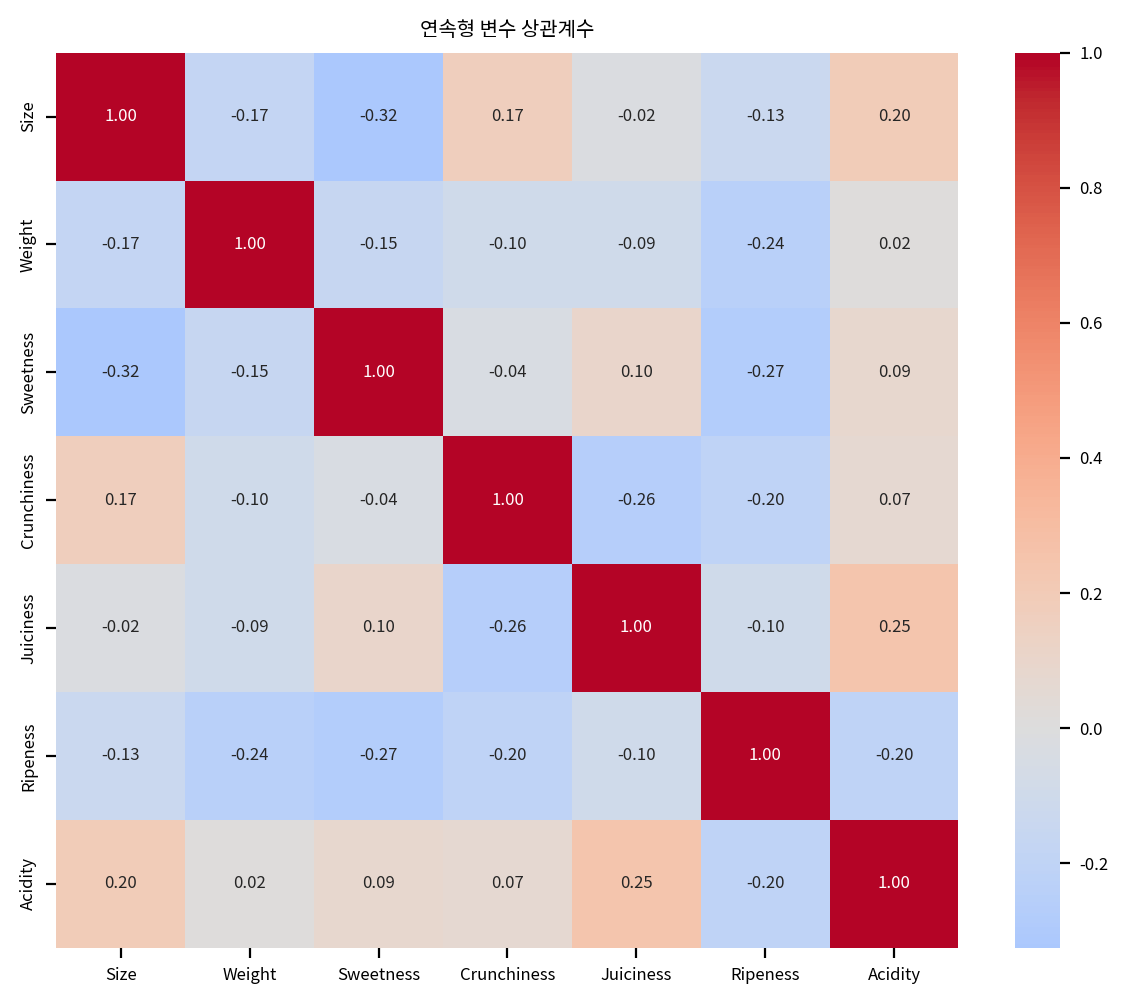

,var1,var2,corr


In [9]:
# 5단계 풀이: 상관계수와 히트맵
feature_cols = [
    "Size",
    "Weight",
    "Sweetness",
    "Crunchiness",
    "Juiciness",
    "Ripeness",
    "Acidity",
]
corr = df[feature_cols].corr()

plt.figure(figsize=(6, 5), dpi=my_dpi)
sb.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("연속형 변수 상관계수")
plt.tight_layout()
plt.show()

high_pairs = [
    {"var1": i, "var2": j, "corr": corr.loc[i, j]}
    for i in feature_cols
    for j in feature_cols
    if i < j and abs(corr.loc[i, j]) >= 0.5
]
display(
    pd.DataFrame(high_pairs)
    if high_pairs
    else pd.DataFrame(columns=["var1", "var2", "corr"])
)

#### 💡 인사이트

- 모든 상관계수가 |r| < 0.35 수준으로 낮아 다중공선성 위험이 거의 없다.
- 따라서 변수 제거는 성능보다 해석·단순성을 위한 선택에 가깝다.

## 6단계. EDA를 바탕으로 한 모델 설계 - “그려본 결과를 어떻게 모델로 옮길까?”

1. 지금까지의 EDA 결과를 간단히 요약하자.
2. 사용할 독립변수를 최종 선정하자.
3. 각 변수 선택에 대해 다음 문장을 완성하자.

```
“이 변수는 EDA 단계에서 ○○한 패턴을 보였기 때문에 품질을 설명하는 데 도움이 될 것으로 판단했다.”
```

> 📌 **출제 의도**
> 변수 선택이 임의가 아니라 **관찰 결과에 근거한 결정**임을 스스로 설명하게 하기 위함이다.

In [10]:
# 6단계 풀이: 모델 변수 선택
model_features = [
    "Size",
    "Sweetness",
    "Juiciness",
    "Ripeness",
    "Acidity",
    "Crunchiness",
]

X_model = df[model_features]
y = df["Quality_bin"]

display(
    pd.DataFrame(
        {"선택 변수": [", ".join(model_features)], "대상 행 수": [len(X_model)]}
    )
)

,선택 변수,대상 행 수
0,"Size, Sweetness, Juiciness, Ripeness, Acidity,...",4000


#### 💡 인사이트

- EDA 요약: good 사과는 더 크고(Size), 더 달고(Sweetness), 더 촉촉(Juiciness)하며 덜 익은(Ripeness↓) 경향을 보였다. 다른 변수 차이는 미미.
- 변수 선택 근거
  - Size: 박스플롯에서 good 중앙값이 크게 높았다 → 큰 사과일수록 품질이 좋을 것으로 판단.
  - Sweetness: good의 평균·중앙값이 확연히 높았다 → 당도가 품질 판단 핵심 신호.
  - Juiciness: good이 더 높았다 → 과즙이 많을수록 품질이 좋다고 해석.
  - Ripeness: bad 쪽이 더 익어 있었다 → 과숙될수록 품질 저하 가능성을 반영.
  - Acidity: 차이는 작지만 상큼함 정도가 맛 균형에 기여할 수 있어 보조 변수로 포함.
  - Crunchiness: 식감 차이는 작았지만 크기·당도와 함께 미세한 영향을 포착하도록 추가.
- Weight는 집단 차이가 거의 없어 제외해 단순성과 해석력을 높였다.

## 7단계. 로지스틱 회귀 모델 적합 - “확률로 말하는 분류기”

1. 로지스틱 회귀 모델을 적합하자.
2. 회귀계수의 부호와 크기를 확인하자.
3. EDA에서 예상한 방향과 결과가 일치하는지 비교하자.

> 📌 **출제 의도**
> 모델 결과를 처음부터 해석 대상으로 보기보다,
> **EDA에서 세운 가설이 어떻게 반영되었는지 확인**하는 과정이다.

In [11]:
# 7단계 풀이: 로지스틱 회귀 적합
X_const = sm.add_constant(X_model)
logit_model = sm.Logit(y, X_const)
logit_fit = logit_model.fit(disp=False)

display(logit_fit.summary2().tables[1])

coef_check = logit_fit.params.drop("const").to_frame("coef")
coef_check["exp(coef)"] = coef_check["coef"].apply(np.exp)
display(coef_check.sort_values("coef", ascending=False))

,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
const,0.421577,0.055344,7.617411,2.588134e-14,0.313105,0.530049
Size,0.557582,0.025521,21.848216,8.082882e-106,0.507562,0.607602
Sweetness,0.478678,0.024966,19.173070,6.213119e-82,0.429745,0.527610
Juiciness,0.399007,0.023357,17.083226,1.978703e-65,0.353229,0.444785
Ripeness,-0.213554,0.023025,-9.274828,1.779058e-20,-0.258683,-0.168426
Acidity,-0.270686,0.020553,-13.170079,1.304617e-39,-0.310969,-0.230403
Crunchiness,-0.016859,0.029544,-0.570635,5.682471e-01,-0.074763,0.041046


,coef,exp(coef)
Size,0.557582,1.746444
Sweetness,0.478678,1.613939
Juiciness,0.399007,1.490344
Crunchiness,-0.016859,0.983283
Ripeness,-0.213554,0.807708
Acidity,-0.270686,0.762856


#### 💡 인사이트

- EDA에서 Size/Sweetness/Juiciness가 good 쪽으로 높고 Ripeness/Acidity가 낮다는 패턴을 확인해 양수·음수를 각각 예상했고, 실제 계수는 Size=0.56, Sweetness=0.48, Juiciness=0.40, Ripeness=-0.21, Acidity=-0.27로 부호가 그대로 일치하며 크기도 당도≈크기>과즙>익음·산미 순으로 강약이 드러났다.
- Crunchiness는 기대했던 것처럼 계수가 거의 0이라 영향이 미미함을 재확인했다.

## 8단계. 오즈비를 통한 해석 - “숫자를 다시 사람의 언어로”

1. 회귀계수를 오즈비로 변환하자.
2. 주요 변수 2~3개를 골라 해석 문장을 작성하자.
3. 이 해석이 EDA 결과와 어떻게 연결되는지 설명하자.

> 📌 **출제 의도**
> 이 단계의 목적은 계산이 아니라 **모델이 말하는 내용을 사람의 언어로 바꾸는 연습**이다.

In [12]:
# 8단계 풀이: 오즈비 해석
ci = logit_fit.conf_int()
or_df = (
    pd.DataFrame(
        {
            "coef": logit_fit.params,
            "OR": np.exp(logit_fit.params),
            "CI_lower": np.exp(ci[0]),
            "CI_upper": np.exp(ci[1]),
            "p_value": logit_fit.pvalues,
        }
    )
    .drop(index="const")
    .sort_values("OR", ascending=False)
)
display(or_df)

,coef,OR,CI_lower,CI_upper,p_value
Size,0.557582,1.746444,1.661237,1.836023,8.082882e-106
Sweetness,0.478678,1.613939,1.536865,1.694877,6.213119e-82
Juiciness,0.399007,1.490344,1.423657,1.560155,1.978703e-65
Crunchiness,-0.016859,0.983283,0.927963,1.041900,5.682471e-01
Ripeness,-0.213554,0.807708,0.772068,0.844994,1.779058e-20
Acidity,-0.270686,0.762856,0.732736,0.794214,1.304617e-39


#### 💡 인사이트

- Size OR≈1.75: (표준화/원단위 변환 없이 주어진 스케일)에서 크기가 1단위 커지면 good 오즈가 약 75% 증가 → 크기가 품질에 가장 큰 플러스 요인.
- Sweetness OR≈1.61: 당도가 1단위 높아지면 good 오즈가 61% 증가 → EDA에서 본 달콤함 효과가 계수로도 재확인.
- Ripeness OR≈0.81: 익은 정도가 1단위 높아질수록 good 오즈가 약 19% 감소 → 과숙이 품질을 떨어뜨리는 흐름과 일치.
- Acidity OR≈0.76: 산미가 강할수록 good 가능성이 낮아지는 편으로, 맛 균형의 한계를 보여줌.

## 9단계. 시각화로 보는 모델 성능 - “모델은 어떤 판단을 하고 있을까?”

1. 혼동행렬을 시각화하자.
2. ROC Curve를 그리고 AUC를 계산하자.
3. ROC Curve의 모양을 말로 설명하자.

> 📌 **출제 의도**
> 성능 지표를 숫자로만 받아들이지 않고, **모델의 판단 특성을 이해하는 도구**로 활용하게 하기 위함이다.

'Quality_bin에 대하여 Size, Sweetness, Juiciness, Ripeness, Acidity, Crunchiness로 예측하는 로지스틱 회귀분석을 실시한 결과, 모형은 통계적으로 유의(χ²(6) = 1340.517, p <= 0.05)하였다.'

'Pseudo R²(McFadden) = 0.242, LLR χ²(6) = 1340.517, p-value = 0.0000, Accuracy = 0.733, AUC = 0.814'

,설명력(P-Rsqe),정확도(Accuracy),정밀도(Precision),"재현율(Recall,TPR)","위양성율(Fallout,FPR)","특이성(Specif city,TNR)",RAS(auc score),F1
0,0.241745,0.733,0.728293,0.74501,0.279058,0.720942,0.814307,0.736556


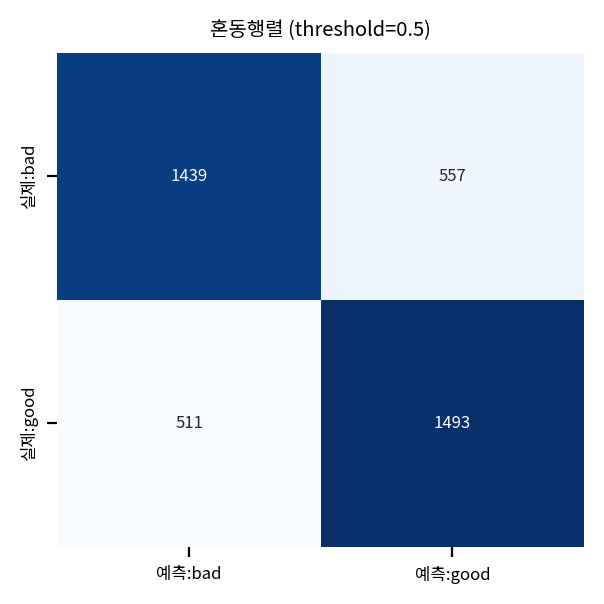

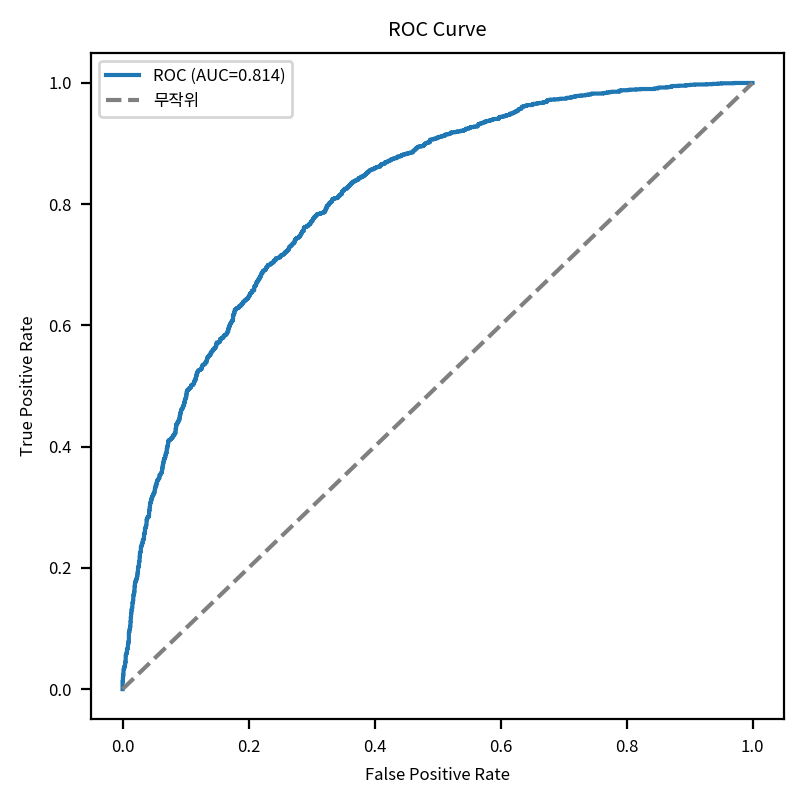

,Accuracy,Precision,Recall,F1,AUC
0,0.733,0.728293,0.74501,0.736556,0.814307


In [15]:
# 9단계 풀이: 혼동행렬과 ROC
cdf, rdf, result_report, model_report, variable_reports = hs_logit_report(
    logit_fit, df[["Quality_bin"] + model_features]
)
display(model_report)
display(result_report)
display(cdf)

pred_prob = logit_fit.predict(X_const)
pred_label = (pred_prob >= 0.5).astype(int)
cm = confusion_matrix(y, pred_label)
plt.figure(figsize=(3, 3), dpi=my_dpi)
sb.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False,
    xticklabels=["예측:bad", "예측:good"],
    yticklabels=["실제:bad", "실제:good"],
)
plt.title("혼동행렬 (threshold=0.5)")
plt.tight_layout()
plt.show()

fpr, tpr, _ = roc_curve(y, pred_prob)
auc = roc_auc_score(y, pred_prob)
plt.figure(figsize=(4, 4), dpi=my_dpi)
plt.plot(fpr, tpr, label=f"ROC (AUC={auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="무작위")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.tight_layout()
plt.show()

metrics_df = pd.DataFrame(
    {
        "Accuracy": [accuracy_score(y, pred_label)],
        "Precision": [precision_score(y, pred_label)],
        "Recall": [recall_score(y, pred_label)],
        "F1": [f1_score(y, pred_label)],
        "AUC": [auc],
    }
)
display(metrics_df)

#### 💡 인사이트

- 혼동행렬: TN=1439, FP=557, FN=511, TP=1493으로 good 재현율(0.745)과 정밀도(0.728)가 비슷한 균형형 모델.
- ROC 곡선이 좌상단으로 볼록하며 AUC=0.81 → 무작위 분류(0.5) 대비 약 31%p 높은 판별력으로 임계값을 어떻게 잡아도 일관된 이득을 준다.
- Accuracy=0.73 수준으로 클래스 균형을 감안하면 무작위(0.5) 대비 개선 효과가 뚜렷하다.

## 10단계. 같은 조건, 다른 판단 - “모델은 어디서 갈림길을 만들었을까?”

1. 가상의 사과 두 개를 설정하자.
2. 예측 확률이 달라진 이유를 분석하자.
3. EDA → 회귀계수 → 확률의 흐름으로 설명하자.

> 📌 **출제 의도**
> 이 단계는 분석의 마무리 단계로, **모델의 판단을 대신 설명할 수 있는지**를 확인하기 위한 문제이다.

In [14]:
# 10단계 풀이: 가상 사례 비교
scenario = pd.DataFrame(
    {
        "Size": [1.0, -1.5],
        "Sweetness": [1.2, -1.0],
        "Juiciness": [1.5, -1.2],
        "Ripeness": [-0.5, 1.2],
        "Acidity": [0.1, 0.5],
        "Crunchiness": [0.5, -0.5],
    },
    index=["달고촉촉한_사과", "덜달고무른_사과"],
)
scenario_const = sm.add_constant(scenario)
scenario["pred_prob"] = logit_fit.predict(scenario_const)
display(scenario)

,Size,Sweetness,Juiciness,Ripeness,Acidity,Crunchiness,pred_prob
달고촉촉한_사과,1.0,1.2,1.5,-0.5,0.1,0.5,0.902328
덜달고무른_사과,-1.5,-1.0,-1.2,1.2,0.5,-0.5,0.147360


#### 💡 인사이트

- `달고촉촉한_사과`는 Size·Sweetness·Juiciness가 높고 Ripeness가 낮아 good 확률 0.90 → EDA에서 중요하다고 본 양의 요인이 모두 높다.
- `덜달고무른_사과`는 당도·과즙이 낮고 Ripeness가 높아 과숙에 가깝다 보니 good 확률 0.15 → 음의 요인이 겹쳐 odds가 크게 줄었다.
- 흐름: EDA에서 확인한 (크고 달고 촉촉하면 good, 과숙하면 bad) 패턴이 계수 부호와 오즈비로 확인되었고, 그 조합이 예측 확률 차이를 만들어 냄. 계수(가중치)×입력값 합이 첫 사례에서는 크게 양수여서 로짓이 +, 두 번째는 음수여서 로짓이 -로 가며 확률이 갈린다.